In [ ]:
"""Main training loop. Fine-tune the whole model"""

import os
import csv
import time
import copy
import json
import pickle
import random
import dnnlib
import numpy as np
import torch
from torch import autocast
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
from solver_utils import get_schedule
from models.ldm.util import instantiate_from_config
from torch_utils.download_util import check_file_by_key
import torchvision.utils as vutils

from torch.utils.tensorboard import SummaryWriter
import glob
#----------------------------------------------------------------------------
# Load pre-trained models from the LDM codebase (https://github.com/CompVis/latent-diffusion) 
# and Stable Diffusion codebase (https://github.com/CompVis/stable-diffusion)

def load_ldm_model(config, ckpt, verbose=False, repeat=1):
    from models.ldm.util import instantiate_from_config
    
    if ckpt.endswith("ckpt"):
        pl_sd = torch.load(ckpt, map_location="cpu", weights_only=False)
        if "global_step" in pl_sd:
            dist.print0(f"Global Step: {pl_sd['global_step']}")
        sd = pl_sd["state_dict"]
    else:
        raise NotImplementedError
    
    config.model.params.unet_config.repeat = repeat
    model = instantiate_from_config(config.model)
    
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    return model

#----------------------------------------------------------------------------

def create_model(dataset_name=None, model_path=None, guidance_type=None, guidance_rate=None, device=None, is_second_stage=False, num_repeats=1):
    print("Function Parameters:")
    for key, value in locals().items():
        print(f"{key}: {value}")

    net_student = None
    if is_second_stage: # for second-stage distillation
        assert model_path is not None
        dist.print0(f'Loading the second-stage teacher model from "{model_path}"...')
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net = pickle.load(f)['model'].to(device)
        model_source = 'edm' if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64'] else 'ldm'
        return net, model_source

    if model_path is None:
        model_path, _ = check_file_by_key(dataset_name)
    dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
    if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:         # models from EDM
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net_temp = pickle.load(f)['ema'].to(device)
        network_kwargs = dnnlib.EasyDict()
        if dataset_name in ['cifar10']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[2,2,2])
            network_kwargs.update(dropout=0.13, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=32, img_channels=3, label_dim=0)
        elif dataset_name in ['ffhq', 'afhqv2']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[1,2,2,2])
            network_kwargs.update(dropout=0.05, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=0)
        else:
            network_kwargs.update(model_type='DhariwalUNet', model_channels=192, channel_mult=[1,2,3,4])
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=1000)
        network_kwargs.class_name = 'models.networks_edm.EDMPrecond'
        net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs) # subclass of torch.nn.Module
        net.to(device)
        net.load_state_dict(net_temp.state_dict(), strict=False)

        network_kwargs.update(repeat=num_repeats)
        net_student = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)
        net_student.to(device)
        net_student.load_state_dict(net_temp.state_dict(), strict=False)

        del net_temp

        net.sigma_min = 0.006
        net.sigma_max = 80.0
        net_student.sigma_min = 0.006
        net_student.sigma_max = 80.0
        model_source = 'edm'
    elif dataset_name in ['lsun_bedroom_ldm', 'ffhq_ldm', 'ms_coco']:   # models from LDM
        from omegaconf import OmegaConf
        from models.networks_edm import CFGPrecond
        if dataset_name in ['lsun_bedroom_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006

            net_student = load_ldm_model(config, model_path, repeat=num_repeats)
            net = CFGPrecond(net_student, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net_student.sigma_min = 0.006

        elif dataset_name in ['ffhq_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/ffhq-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006

            net_student = load_ldm_model(config, model_path, repeat=num_repeats)
            net_student = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net_student.sigma_min = 0.006

        elif dataset_name in ['ms_coco']:
            assert guidance_type == 'cfg'
            config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net.sigma_min = 0.1

            net_student = load_ldm_model(config, model_path)
            net_student = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net_student.sigma_min = 0.1

        model_source = 'ldm'
    else:
        raise ValueError(f"Unsupported dataset_name: {dataset_name}")
    
    return net, net_student, model_source




In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")

# Define the loss_xs dictionary
loss_xs = {
    0: [0.26207373, 0.30109838, 0.31655908, 0.70233226],
    1: [1.1221931, 1.151793, 1.92400157, 4.4905653],
    2: [4.44061422, 4.65574169, 4.91851616, 5.02707195]
}

# Function to calculate multipliers for a weight list and a given step
def compute_multipliers(weight_ls, loss_x_list):
    denominator = sum(wi * xi for wi, xi in zip(weight_ls, loss_x_list))
    multipliers = [(wi * loss_x_list[-1]) / denominator for wi in weight_ls]
    return multipliers

# Extract weight lists
df['weight_list'] = df[['w1', 'w2', 'w3', 'w4']].values.tolist()

# Compute multipliers for all steps
for step, loss_x_list in loss_xs.items():
    df[f'multipliers_step_{step}'] = df['weight_list'].apply(lambda wl: compute_multipliers(wl, loss_x_list))

# Sort the dataframe by fid_score ascending
df_sorted = df.sort_values(by='fid_score')

# Print sorted weight lists with multipliers for all steps
for _, row in df_sorted.iterrows():
    print(f"FID: {row['fid_score']:.4f}, Weight list: {row['weight_list']}")
    for step in loss_xs.keys():
        print(f"  Step {step} multipliers: {row[f'multipliers_step_{step}']}")
    print()


In [3]:
import optuna
import pandas as pd

# Path to your Optuna SQLite database
study_path = "sqlite:////home/cherish/SADD/sfd-main/fid_optimization.db"

# Load all studies
storage = optuna.storages.RDBStorage(url=study_path)
study_summaries = optuna.study.get_all_study_summaries(storage=storage)

print("Available studies:")
for s in study_summaries:
    print(f"- {s.study_name}")

# If you know the study name, load it
study_name = study_summaries[0].study_name  # take first one
study = optuna.load_study(study_name=study_name, storage=study_path)

# Extract all trials into a dataframe
df = study.trials_dataframe(attrs=("number", "value", "params", "state", "datetime_start", "datetime_complete"))

# Display the dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
print(df)


Available studies:
- diffusion_fid_optimization
    number     value  params_a  params_b     state             datetime_start          datetime_complete
0        0  4.457271  2.316697 -5.766729  COMPLETE 2025-10-07 21:45:50.263659 2025-10-07 22:47:03.468422
1        1  4.453282  2.731463 -6.972348  COMPLETE 2025-10-07 22:47:03.481343 2025-10-07 23:48:24.775997
2        2  4.432436  1.463343 -4.135815  COMPLETE 2025-10-07 23:48:24.800574 2025-10-08 00:49:46.957204
3        3  4.437785  2.091351 -6.289821  COMPLETE 2025-10-08 00:49:46.965325 2025-10-08 01:51:15.116567
4        4  4.444075  2.295946 -6.139241  COMPLETE 2025-10-08 01:51:15.130878 2025-10-08 02:52:40.891972
5        5       NaN  2.988784       NaN    PRUNED 2025-10-08 02:52:40.904815 2025-10-08 02:52:40.914388
6        6  4.589819  0.677427 -2.134352  COMPLETE 2025-10-08 02:52:40.919693 2025-10-08 03:54:03.414532
7        7  4.676017  0.533640 -2.837761  COMPLETE 2025-10-08 03:54:03.431157 2025-10-08 04:55:20.434527
8      

In [2]:
import sqlite3

# Path to your Optuna DB
db_path = "/home/cherish/SADD/sfd-main/fid_optimization.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# View all trial numbers before deleting (just to confirm)
cursor.execute("SELECT trial_id, number, state FROM trials ORDER BY number DESC;")
print(cursor.fetchall())

# Delete the last trial (number 27)
cursor.execute("DELETE FROM trials WHERE number = 27;")
cursor.execute("DELETE FROM trial_params WHERE trial_id NOT IN (SELECT trial_id FROM trials);")
cursor.execute("DELETE FROM trial_values WHERE trial_id NOT IN (SELECT trial_id FROM trials);")
cursor.execute("DELETE FROM trial_user_attributes WHERE trial_id NOT IN (SELECT trial_id FROM trials);")
cursor.execute("DELETE FROM trial_system_attributes WHERE trial_id NOT IN (SELECT trial_id FROM trials);")

conn.commit()
conn.close()

print("✅ Trial #27 and all related data have been deleted.")


[(28, 27, 'RUNNING'), (27, 26, 'COMPLETE'), (26, 25, 'COMPLETE'), (25, 24, 'COMPLETE'), (24, 23, 'COMPLETE'), (23, 22, 'COMPLETE'), (22, 21, 'COMPLETE'), (21, 20, 'COMPLETE'), (20, 19, 'COMPLETE'), (19, 18, 'COMPLETE'), (18, 17, 'COMPLETE'), (17, 16, 'COMPLETE'), (16, 15, 'COMPLETE'), (15, 14, 'COMPLETE'), (14, 13, 'COMPLETE'), (13, 12, 'COMPLETE'), (12, 11, 'COMPLETE'), (11, 10, 'COMPLETE'), (10, 9, 'COMPLETE'), (9, 8, 'COMPLETE'), (8, 7, 'COMPLETE'), (7, 6, 'COMPLETE'), (6, 5, 'PRUNED'), (5, 4, 'COMPLETE'), (4, 3, 'COMPLETE'), (3, 2, 'COMPLETE'), (2, 1, 'COMPLETE'), (1, 0, 'COMPLETE')]
✅ Trial #27 and all related data have been deleted.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a 'group' column: low, mid, high FID
n = len(df_sorted)
df_sorted['fid_group'] = pd.cut(df_sorted['fid_score'],
                                bins=[df_sorted['fid_score'].min()-1,
                                      df_sorted['fid_score'].quantile(0.25),
                                      df_sorted['fid_score'].quantile(0.75),
                                      df_sorted['fid_score'].max()+1],
                                labels=['low', 'mid', 'high'])

# Plot weight distributions per group
weights = ['w1','w2','w3','w4']
plt.figure(figsize=(12,6))
for i, w in enumerate(weights,1):
    plt.subplot(1,4,i)
    sns.boxplot(x='fid_group', y=w, data=df_sorted)
    plt.title(w)
plt.tight_layout()
plt.show()


In [12]:
# assume you already have step_2_losses from your find_min_s2_loss logic
# e.g.:
import re

log_path = '/home/cherish/SADD/sfd-main/exps/00054-cifar10-4-3-dpmpp-3-poly7.0/log.txt'
all_losses = [[] for _ in range(3)]
pattern = re.compile(r"Step:\s*(\d+)\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")
with open(log_path, 'r') as f:
    for line in f:
        m = pattern.search(line)
        if m:
            step = int(m.group(1))
            loss = float(m.group(2))
            if 0 <= step < 3:
                all_losses[step].append(loss)

step_2_losses = all_losses[2]

# now find the min and its iteration index
min_loss = min(step_2_losses)
min_iter = step_2_losses.index(min_loss)
print(f"Min Step-2 loss {min_loss:.6f} occurred at iteration index {min_iter}")

Min Step-2 loss 4.244495 occurred at iteration index 1133


In [10]:
find_min_s2_loss("/home/cherish/SADD/sfd-main/exps/00054-cifar10-4-3-dpmpp-3-poly7.0/log.txt")

1563


4.24449539

In [4]:
def find_min_s2_loss(log_path: str) -> float:
    """
    Parse the log file to extract all Step 2 Loss_ls-3-mean values
    and return their minimum.
    """
    
    step2_losses = []
    
    # Pattern to match Step 2 Loss_ls-3-mean lines
    step2_loss_pattern = re.compile(r"Step:\s*2\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")

    
    with open(log_path, 'r') as f:
        for line in f:
            match = step2_loss_pattern.search(line)
            if match:
                loss_value = float(match.group(1))
                step2_losses.append(loss_value)
                # print(f"Found Step 2 Loss_ls-3-mean: {loss_value}")
    
    if not step2_losses:
        raise ValueError("No Step 2 Loss_ls-3-mean values found")
    
    min_loss = min(step2_losses)
    # print(f"\nAll Step 2 Loss_ls-3-mean values: {step2_ls3_losses}")
    # print(f"Total count: {len(step2_ls3_losses)}")
    # print(f"Minimum Step 2 Loss_ls-3-mean: {min_loss}")
    
    return min_loss

In [5]:
import re
find_min_s2_loss("/teamspace/studios/this_studio/sfd-main/training/original_training_logs.txt")

4.69043016

In [8]:
import pickle

pkl_path = '/teamspace/studios/this_studio/sfd-main/exps/teacher_model/edm-cifar10-32x32-cond-vp.pkl'  # replace with your .pkl file path
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

if hasattr(data, 'keys'):
    print("Keys in the pickle file:", list(data.keys()))
else:
    print(f"Loaded object is a {type(data)}, which has no .keys()")

Keys in the pickle file: ['ema', 'loss_fn', 'augment_pipe', 'dataset_kwargs']


In [ ]:
# Print the state_dict of the model inside the loaded pickle
state_dict = data['ema'].model.state_dict()
print("Model state_dict keys and tensor shapes:")
for name, tensor in state_dict.items():
    print(f"{name}: {tuple(tensor.shape)}")

In [1]:
import re
import matplotlib.pyplot as plt

def get_fid_values(file_path, prefix_id):
    """
    Extracts FID values from fid.txt for a given prefix_id (0 or 1).

    Args:
        file_path (str): Path to fid.txt
        prefix_id (int): 0 -> "00000", 1 -> "00001"

    Returns:
        list: Extracted FID values
    """
    prefix = f"{prefix_id:05d}"  # formats 0 -> "00000", 1 -> "00001"
    # pattern = re.compile(rf"{prefix}-cifar10-4-3-dpmpp-3-poly7\.0_netwrol_snapshot_\d+\s+([\d\.]+)")
    pattern = re.compile(rf"{prefix}-cifar10-4-\d-dpmpp-3-poly7\.0.*?_netwrol_snapshot_\d+\s+([\d\.]+)")

    values = []
    with open(file_path, "r") as f:
        
        for line in f:
            match = pattern.search(line)
            if match:
                values.append(float(match.group(1)))
    return values

# Example usage
file_path = "fid.txt"

values_00 = get_fid_values(file_path, 0)
values_11 = get_fid_values(file_path, 1)



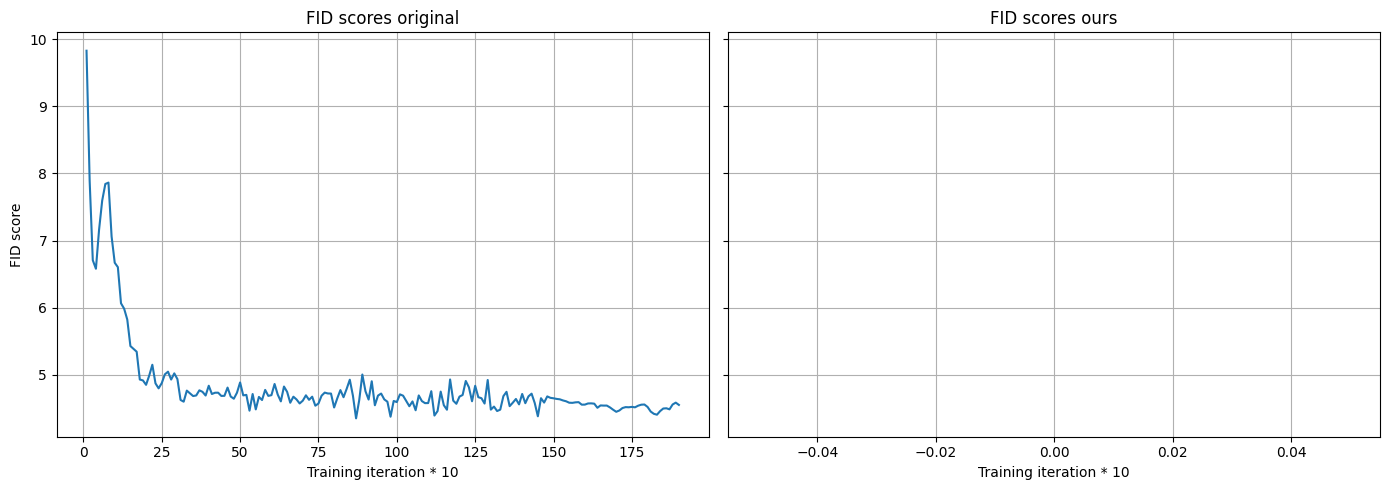

In [8]:
import matplotlib.pyplot as plt

values_0 = values_00[9:]
values_1 = values_11[10:]
# Generate x-axis as natural numbers
nums_0 = list(range(1, len(values_0) + 1))
nums_1 = list(range(1, len(values_1) + 1))

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot values_0
axes[0].plot(nums_0, values_0, linestyle='-')
axes[0].set_title("FID scores original")
axes[0].set_xlabel("Training iteration * 10")
axes[0].set_ylabel("FID score")
axes[0].grid(True)

# Plot values_1
axes[1].plot(nums_1, values_1, linestyle='-', color='orange')
axes[1].set_title("FID scores ours")
axes[1].set_xlabel("Training iteration * 10")
axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Load CSV
df = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")

# Sort by fid_score ascending
df_sorted = df.sort_values(by="fid_score", ascending=True)

# Select only w1–w4 columns
weights_df = df_sorted[["w1", "w2", "w3", "w4"]]

# Show all floats with full precision
pd.set_option("display.float_format", "{:.16f}".format)

# Print neatly
print(weights_df.to_string(index=False))


                w1                 w2                 w3                 w4
0.0168169338469557 0.0575429182802859 0.1968960260143427 0.6737239997353861
0.0150565765163528 0.0573856337276224 0.2187157854074077 0.8335987890877504
0.0139210542980094 0.0557095339234981 0.2229394486606637 0.8921632307563885
0.0159631598274761 0.0573198447019583 0.2058216939607056 0.7390559050730826
0.0148802078120299 0.0533830113237393 0.1915125066792815 0.6870545386088324
0.0103020854245742 0.0454214912363379 0.2002615762835205 0.8829454481555168
0.0124817892649062 0.0467280578272939 0.1749357677789091 0.6549068005672904
0.0139055652373106 0.0564629816899471 0.2292656391101063 0.9309237965008847
0.0145401271517582 0.0519263630753616 0.1854417883758488 0.6622581447910041
0.0073457756922118 0.0337421581533759 0.1549915603949803 0.7119397545490830
0.0086559788539043 0.0353114846971643 0.1440508315192628 0.5876456976915903
0.0092997908340821 0.0374601086160265 0.1508915375152103 0.6078000554425295
0.0098636569

In [ ]:
def find_min_s2_loss(log_path: str) -> float:
    """
    Parse the log file to extract all Step 2 Loss_ls-3-mean values
    and return their minimum.
    """
    step2_ls3_losses = []
    step2_ls3_pattern = re.compile(r"Step:\s*2\s*\|\s*Loss_ls-3-mean:\s*([0-9]+\.[0-9]+)")

    with open(log_path, 'r') as f:
        for line in f:
            match = step2_ls3_pattern.search(line)
            if match:
                loss_value = float(match.group(1))
                step2_ls3_losses.append(loss_value)

    if not step2_ls3_losses:
        raise ValueError(f"No Step 2 Loss_ls-3-mean found in {log_path}")

    return min(step2_ls3_losses)

In [1]:
import re

def sum_s2_loss(log_path: str) -> float:
    """
    Parse the log file to extract all Step 2 Loss_ls-3-mean values
    and return their sum.
    """
    total_loss = 0.0
    count = 0
    step2_ls3_pattern = re.compile(r"Step:\s*2\s*\|\s*Loss_ls-3-mean:\s*([-+]?\d*\.\d+)")

    with open(log_path, 'r') as f:
        for line in f:
            match = step2_ls3_pattern.search(line)
            if match:
                loss_value = float(match.group(1))
                total_loss += loss_value
                count += 1

    if count == 0:
        raise ValueError(f"No Step 2 Loss_ls-3-mean found in {log_path}")

    return total_loss

# original total 8917.848242209995
#original min 4.65499163
for i in range(100):
    try:
        l = sum_s2_loss(f"/home/cherish/SADD/sfd-main/exps/{i:05d}-cifar10-4-2-dpmpp-3-poly7.0-afs/log.txt")
        if l < 8917.848242209995:
            print(f"Run {i}: {l}")
    except:
        continue


Run 2: 8915.351645130013
Run 7: 8888.589185699988
Run 10: 8884.489788520003
Run 11: 8885.665466370005
Run 12: 8909.623018729995
Run 15: 8872.51209735998
Run 16: 8863.134339050004
Run 17: 8870.652382410008
Run 18: 8881.659530679992
Run 19: 8885.006684810009
Run 20: 8843.668534190007
Run 21: 8847.434110779994
Run 22: 8844.681770710016
Run 23: 8843.534351780012
Run 24: 8838.260136560008
Run 25: 8844.997862860017
Run 26: 8852.882403380001
Run 27: 8887.07422405
Run 28: 8856.951214709998
Run 29: 8894.198098279985
Run 30: 8857.03209527998
Run 31: 8839.691317050014
Run 32: 8891.24603484
Run 33: 8841.708628989998
Run 34: 8841.290248470006
Run 35: 8839.248812890004
Run 36: 8844.695399340011
Run 37: 8878.38940799999
Run 39: 8909.390041839995
Run 41: 8838.39344365001
Run 42: 8831.594192450013
Run 43: 8829.920761700003
Run 44: 8845.659218479985
Run 45: 8830.65674157002
Run 46: 8832.645763930028
Run 47: 8830.751559339998
Run 48: 8832.973006339978
Run 49: 8831.475998729997


In [3]:
import os 
def find_fid_score(fid_file_path: str, exp_folder: str) -> float:
    """
    Parse the fid.txt file to extract FID score for the given experiment folder.
    Looks for lines like: "exp_folder_description FID_SCORE"
    """
    if not os.path.exists(fid_file_path):
        raise FileNotFoundError(f"FID file not found: {fid_file_path}")
    
    with open(fid_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith(exp_folder):
                # Extract the last number from the line (FID score)
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        fid_score = float(parts[-1])
                        return fid_score
                    except ValueError:
                        continue
    
    raise ValueError(f"No FID score found for {exp_folder} in {fid_file_path}")

find_fid_score("/home/cherish/SADD/sfd-main/fid.txt","00050-cifar10-4-2-dpmpp-3-poly7.0-afs")


4.5060315425715505

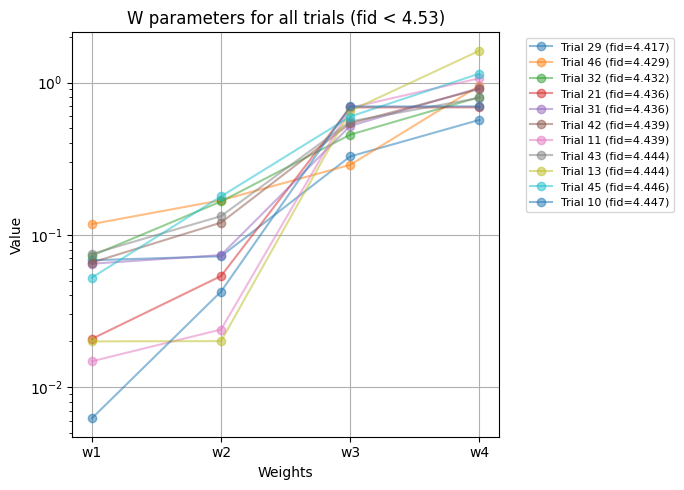

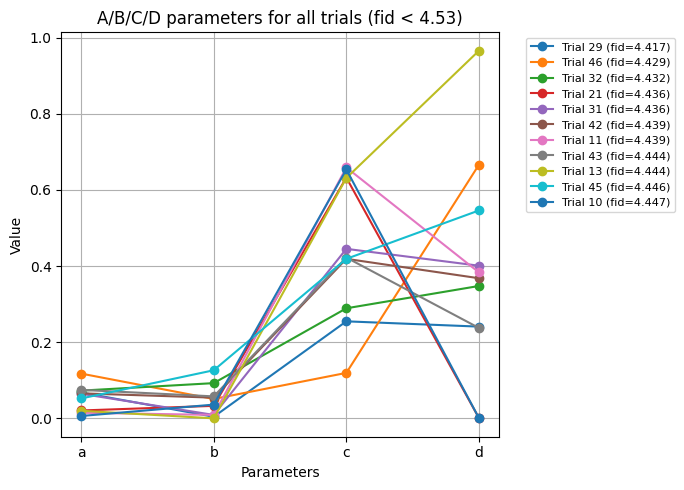

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")

# Filter and sort
filtered = df[df['fid_score'] < 4.45].sort_values(by='fid_score')

# --- Plot 1: all w curves ---
plt.figure(figsize=(7, 5))
for _, row in filtered.iterrows():
    plt.plot(['w1', 'w2', 'w3', 'w4'],
             [row['w1'], row['w2'], row['w3'], row['w4']],
             marker='o', label=f"Trial {row['trial_number']} (fid={row['fid_score']:.3f})", alpha=0.5)
plt.title("W parameters for all trials (fid < 4.53)")
plt.xlabel("Weights")
plt.ylabel("Value")
plt.yscale('log')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 2: all a/b/c/d curves ---
plt.figure(figsize=(7, 5))
for _, row in filtered.iterrows():
    plt.plot(['a', 'b', 'c', 'd'],
             [row['a'], row['b'], row['c'], row['d']],
             marker='o', label=f"Trial {row['trial_number']} (fid={row['fid_score']:.3f})")
plt.title("A/B/C/D parameters for all trials (fid < 4.53)")
plt.xlabel("Parameters")
plt.ylabel("Value")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
[0.26207373, 0.30109838]

[0.26207373, 0.30109838, 0.31655908, 0.70233226]

Estimated a range (positive): (0.7261926275455984, 2.3299848545285173)
Estimated b range (can be negative): (-6.716415162947573, -2.270736060624487)


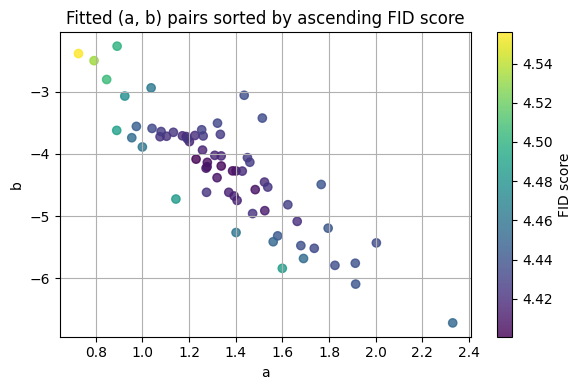

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
# df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")


# Filter for good trials
# df2 = df2[df2['fid_score'] < 4.53]

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue  # skip invalid

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']

    fits.append((fid, a, b))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b'])

# Filter for positive a
fits_df = fits_df[fits_df['a'] > 0]

# Sort by fid_score ascending
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Compute ranges
a_min, a_max = fits_df['a'].min(), fits_df['a'].max()
b_min, b_max = fits_df['b'].min(), fits_df['b'].max()

print("Estimated a range (positive):", (a_min, a_max))
print("Estimated b range (can be negative):", (b_min, b_max))

# Plot
plt.figure(figsize=(6,4))
sc = plt.scatter(fits_df['a'], fits_df['b'],
                 c=fits_df['fid_score'],
                 cmap='viridis', alpha=0.8)
plt.colorbar(sc, label='FID score')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Fitted (a, b) pairs sorted by ascending FID score')
plt.grid(True)
plt.tight_layout()
plt.show()


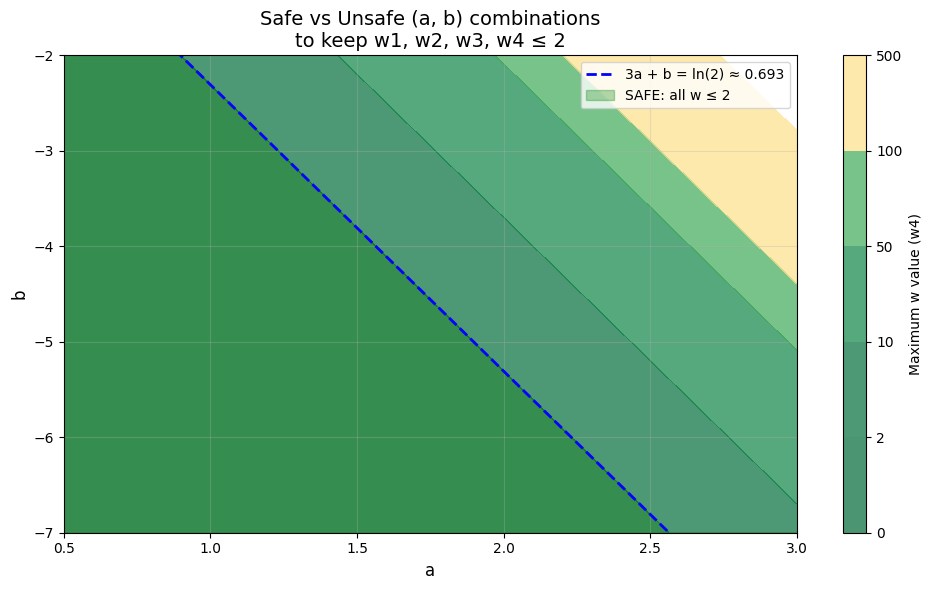

RULE TO AVOID LARGE VALUES:
To keep all w values ≤ 2:
AVOID: 3a + b > 0.693

Or equivalently:
SAFE when: b ≤ 0.693 - 3a

Examples:
--------------------------------------------------
a = 0.5 → b must be ≤ -0.81
a = 1.0 → b must be ≤ -2.31
a = 1.5 → b must be ≤ -3.81
a = 2.0 → b must be ≤ -5.31
a = 2.5 → b must be ≤ -6.81
a = 3.0 → b must be ≤ -8.31


In [57]:
import numpy as np
import matplotlib.pyplot as plt

a_range = (0.5, 3)
b_range = (-7, -2)

# Create a grid of a and b values
a_vals = np.linspace(a_range[0], a_range[1], 100)
b_vals = np.linspace(b_range[0], b_range[1], 100)
A, B = np.meshgrid(a_vals, b_vals)

# Calculate max w value (w4) for each combination
i_max = 3
W_max = np.exp(i_max * A + B)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot contours
contour = plt.contourf(A, B, W_max, levels=[0, 2, 10, 50, 100, 500], 
                        cmap='RdYlGn_r', alpha=0.7)
plt.colorbar(contour, label='Maximum w value (w4)')

# Add the constraint line: 3a + b = ln(2)
constraint_b = np.log(2) - 3 * a_vals
plt.plot(a_vals, constraint_b, 'b--', linewidth=2, label='3a + b = ln(2) ≈ 0.693')

# Shade the safe region
plt.fill_between(a_vals, constraint_b, b_range[0], alpha=0.3, color='green', 
                 label='SAFE: all w ≤ 2')

plt.xlabel('a', fontsize=12)
plt.ylabel('b', fontsize=12)
plt.title('Safe vs Unsafe (a, b) combinations\nto keep w1, w2, w3, w4 ≤ 2', fontsize=14)
plt.xlim(a_range)
plt.ylim(b_range)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("RULE TO AVOID LARGE VALUES:")
print("=" * 50)
print("To keep all w values ≤ 2:")
print("AVOID: 3a + b > 0.693")
print("\nOr equivalently:")
print("SAFE when: b ≤ 0.693 - 3a")
print("\nExamples:")
print("-" * 50)
for a in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    b_max = np.log(2) - 3 * a
    print(f"a = {a:.1f} → b must be ≤ {b_max:.2f}")

Estimated a range (positive): (np.float64(0.5336400618771782), np.float64(2.731462900922447))
Estimated b range (can be negative): (np.float64(-6.972348221687252), np.float64(-2.1343519866009464))


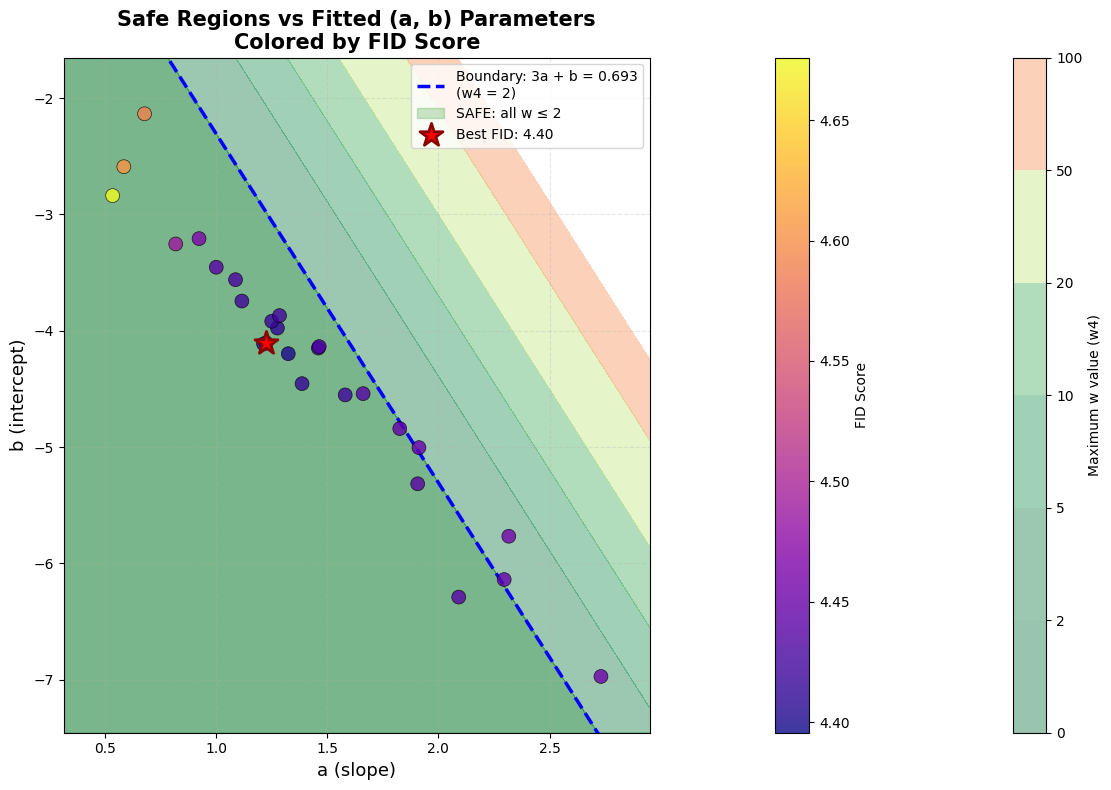


ANALYSIS:

Total points: 26
Safe points (w4 ≤ 2): 22 (84.6%)
Unsafe points (w4 > 2): 4 (15.4%)

Best FID score: 4.396
  a = 1.225, b = -4.104

Best SAFE FID score: 4.396
  a = 1.225, b = -4.104


In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
# df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue  # skip invalid

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']

    fits.append((fid, a, b))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b'])

# Filter for positive a
fits_df = fits_df[fits_df['a'] > 0]

# Sort by fid_score ascending
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Compute ranges for the plot
a_min, a_max = fits_df['a'].min(), fits_df['a'].max()
b_min, b_max = fits_df['b'].min(), fits_df['b'].max()

# Add some padding to the ranges
a_padding = (a_max - a_min) * 0.1
b_padding = (b_max - b_min) * 0.1
a_range = (max(0, a_min - a_padding), a_max + a_padding)
b_range = (b_min - b_padding, b_max + b_padding)

print("Estimated a range (positive):", (a_min, a_max))
print("Estimated b range (can be negative):", (b_min, b_max))

# Create a grid of a and b values for the background
a_vals = np.linspace(a_range[0], a_range[1], 200)
b_vals = np.linspace(b_range[0], b_range[1], 200)
A, B = np.meshgrid(a_vals, b_vals)

# Calculate max w value (w4) for each combination
i_max = 3
W_max = np.exp(i_max * A + B)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot contours for the safe/unsafe regions
contour = ax.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 50, 100], 
                       cmap='RdYlGn_r', alpha=0.4)
cbar1 = plt.colorbar(contour, ax=ax, label='Maximum w value (w4)', pad=0.1)

# Add the constraint line: 3a + b = ln(2)
constraint_b = np.log(2) - 3 * a_vals
ax.plot(a_vals, constraint_b, 'b--', linewidth=2.5, 
        label='Boundary: 3a + b = 0.693\n(w4 = 2)', zorder=5)

# Shade the safe region
ax.fill_between(a_vals, constraint_b, b_range[0], alpha=0.2, color='green', 
                label='SAFE: all w ≤ 2', zorder=1)

# Plot the fitted (a, b) points colored by FID score
sc = ax.scatter(fits_df['a'], fits_df['b'],
                c=fits_df['fid_score'],
                cmap='plasma', 
                s=100, 
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
                zorder=10)
cbar2 = plt.colorbar(sc, ax=ax, label='FID Score', pad=0.15)

# Mark the best FID point
best_idx = fits_df['fid_score'].idxmin()
best_row = fits_df.loc[best_idx]
ax.scatter(best_row['a'], best_row['b'], 
          s=300, marker='*', color='red', 
          edgecolors='darkred', linewidths=2,
          label=f'Best FID: {best_row["fid_score"]:.2f}',
          zorder=15)

ax.set_xlabel('a (slope)', fontsize=13)
ax.set_ylabel('b (intercept)', fontsize=13)
ax.set_title('Safe Regions vs Fitted (a, b) Parameters\nColored by FID Score', 
             fontsize=15, fontweight='bold')
ax.set_xlim(a_range)
ax.set_ylim(b_range)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*60)
print("ANALYSIS:")
print("="*60)
safe_threshold = np.log(2) - 3 * fits_df['a']
fits_df['is_safe'] = fits_df['b'] <= safe_threshold
n_safe = fits_df['is_safe'].sum()
n_total = len(fits_df)

print(f"\nTotal points: {n_total}")
print(f"Safe points (w4 ≤ 2): {n_safe} ({100*n_safe/n_total:.1f}%)")
print(f"Unsafe points (w4 > 2): {n_total - n_safe} ({100*(n_total-n_safe)/n_total:.1f}%)")

print(f"\nBest FID score: {fits_df['fid_score'].min():.3f}")
print(f"  a = {best_row['a']:.3f}, b = {best_row['b']:.3f}")
# print(f"  Is safe? {best_row['is_safe']}")

if n_safe > 0:
    safe_df = fits_df[fits_df['is_safe']]
    best_safe_idx = safe_df['fid_score'].idxmin()
    best_safe = safe_df.loc[best_safe_idx]
    print(f"\nBest SAFE FID score: {best_safe['fid_score']:.3f}")
    print(f"  a = {best_safe['a']:.3f}, b = {best_safe['b']:.3f}")

ANALYSIS OF BEST PERFORMING REGIONS

📊 TOP 10% PERFORMERS:
FID range: 4.372 - 4.380
a range:   1.018 - 1.176
b range:   -3.224 - -2.972
w4 range:  0.86 - 1.51

📊 TOP 25% PERFORMERS:
FID range: 4.372 - 4.386
a range:   0.856 - 2.453
b range:   -5.891 - -2.758
w4 range:  0.61 - 4.34

🎯 OPTUNA RANGE RECOMMENDATIONS

🔍 STRATEGY 1: Exploit Best Region (Conservative)
   Focus on refining around proven good performers
   a_range = (0.971, 1.223)
   b_range = (-3.299, -2.896)
   Expected w4: ~2.2 max

⚖️  STRATEGY 2: Balanced Exploration
   Cover good performers + unexplored promising areas
   a_range = (0.3, 1.5)
   b_range = (-4.5, -0.5)
   Expected w4: ~54.6 max

🛡️  STRATEGY 3: Constrained (w4 ≤ 5)
   Keep weights more controlled
   a_range = (0.2, 1.2)
   b_range = (-0.991, 1.009)
   Guaranteed w4 ≤ 5

🚀 STRATEGY 4: Aggressive - Dense Good Region
   Intensively search the densest cluster of good performers
   a_range = (0.6, 1.1)
   b_range = (-3.0, -1.3)
   Expected w4: ~7.4 max

⚠️  REG

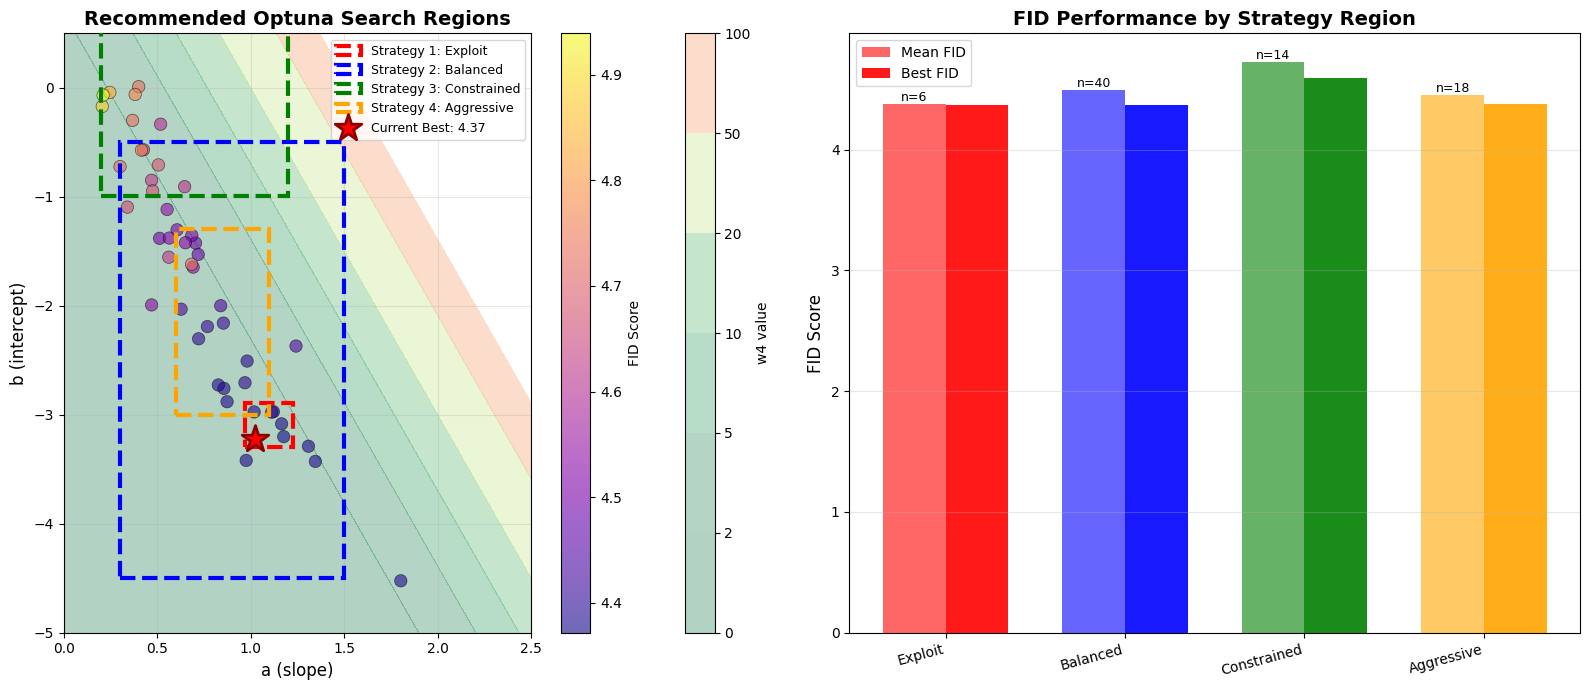


💡 RECOMMENDATION

Based on your data:

1. START with Strategy 4 (Aggressive) for 100-200 trials
   - This targets the densest cluster of good performers
   - High chance of finding improvements

2. If you need better FID at any cost:
   - Use Strategy 2 (Balanced) - allows larger w4 values
   
3. If you need controlled weights (w4 < 5):
   - Use Strategy 3 (Constrained)
   
4. For fine-tuning after finding a good region:
   - Use Strategy 1 (Exploit) with narrow ranges

Example Optuna code:
```python
def objective(trial):
    a = trial.suggest_float('a', 0.6, 1.1)  # Strategy 4
    b = trial.suggest_float('b', -3.0, -1.3)
    # ... rest of your code
```



In [61]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    # Calculate actual w4 value
    w4 = np.exp(3*a + b)
    fits.append((fid, a, b, w4))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Analyze best performing regions
top_10_percent = fits_df.head(int(len(fits_df) * 0.1))
top_25_percent = fits_df.head(int(len(fits_df) * 0.25))

print("="*70)
print("ANALYSIS OF BEST PERFORMING REGIONS")
print("="*70)

print("\n📊 TOP 10% PERFORMERS:")
print(f"FID range: {top_10_percent['fid_score'].min():.3f} - {top_10_percent['fid_score'].max():.3f}")
print(f"a range:   {top_10_percent['a'].min():.3f} - {top_10_percent['a'].max():.3f}")
print(f"b range:   {top_10_percent['b'].min():.3f} - {top_10_percent['b'].max():.3f}")
print(f"w4 range:  {top_10_percent['w4'].min():.2f} - {top_10_percent['w4'].max():.2f}")

print("\n📊 TOP 25% PERFORMERS:")
print(f"FID range: {top_25_percent['fid_score'].min():.3f} - {top_25_percent['fid_score'].max():.3f}")
print(f"a range:   {top_25_percent['a'].min():.3f} - {top_25_percent['a'].max():.3f}")
print(f"b range:   {top_25_percent['b'].min():.3f} - {top_25_percent['b'].max():.3f}")
print(f"w4 range:  {top_25_percent['w4'].min():.2f} - {top_25_percent['w4'].max():.2f}")

print("\n" + "="*70)
print("🎯 OPTUNA RANGE RECOMMENDATIONS")
print("="*70)

# Strategy 1: Explore around best performers
a_best_min = top_10_percent['a'].min()
a_best_max = top_10_percent['a'].max()
b_best_min = top_10_percent['b'].min()
b_best_max = top_10_percent['b'].max()

a_margin = (a_best_max - a_best_min) * 0.3
b_margin = (b_best_max - b_best_min) * 0.3

strategy1_a = (max(0.01, a_best_min - a_margin), a_best_max + a_margin)
strategy1_b = (b_best_min - b_margin, b_best_max + b_margin)

print("\n🔍 STRATEGY 1: Exploit Best Region (Conservative)")
print("   Focus on refining around proven good performers")
print(f"   a_range = ({strategy1_a[0]:.3f}, {strategy1_a[1]:.3f})")
print(f"   b_range = ({strategy1_b[0]:.3f}, {strategy1_b[1]:.3f})")
print(f"   Expected w4: ~{np.exp(3*strategy1_a[1] + strategy1_b[1]):.1f} max")

# Strategy 2: Balanced exploration
strategy2_a = (0.3, 1.5)
strategy2_b = (-4.5, -0.5)

print("\n⚖️  STRATEGY 2: Balanced Exploration")
print("   Cover good performers + unexplored promising areas")
print(f"   a_range = {strategy2_a}")
print(f"   b_range = {strategy2_b}")
print(f"   Expected w4: ~{np.exp(3*strategy2_a[1] + strategy2_b[1]):.1f} max")

# Strategy 3: Constrained by w4 limit
max_w4_desired = 5  # You can adjust this
strategy3_a = (0.2, 1.2)
strategy3_b_max = np.log(max_w4_desired) - 3 * strategy3_a[0]
strategy3_b = (strategy3_b_max - 2, strategy3_b_max)

print("\n🛡️  STRATEGY 3: Constrained (w4 ≤ 5)")
print("   Keep weights more controlled")
print(f"   a_range = {strategy3_a}")
print(f"   b_range = ({strategy3_b[0]:.3f}, {strategy3_b[1]:.3f})")
print(f"   Guaranteed w4 ≤ {max_w4_desired}")

# Strategy 4: Aggressive exploration in promising dense region
strategy4_a = (0.6, 1.1)
strategy4_b = (-3.0, -1.3)

print("\n🚀 STRATEGY 4: Aggressive - Dense Good Region")
print("   Intensively search the densest cluster of good performers")
print(f"   a_range = {strategy4_a}")
print(f"   b_range = {strategy4_b}")
print(f"   Expected w4: ~{np.exp(3*strategy4_a[1] + strategy4_b[1]):.1f} max")

print("\n" + "="*70)
print("⚠️  REGIONS TO AVOID")
print("="*70)
print("\n❌ AVOID: a > 1.5 AND b > -2")
print("   → This produces extremely large w4 values (>100)")
print("\n❌ AVOID: a < 0.2")
print("   → Weights become too flat/uniform, less expressive")
print("\n❌ AVOID: b > 0")
print("   → All weights become large")
print("\n❌ AVOID: 3a + b > 3.0")
print("   → w4 > 20, likely too extreme")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Recommended regions
ax1 = axes[0]
a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 50, 100], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Plot all points
sc1 = ax1.scatter(fits_df['a'], fits_df['b'],
                  c=fits_df['fid_score'],
                  cmap='plasma', s=80, alpha=0.6,
                  edgecolors='black', linewidths=0.5, zorder=10)
plt.colorbar(sc1, ax=ax1, label='FID Score')

# Draw strategy rectangles
strategies = [
    (strategy1_a, strategy1_b, 'red', 'Strategy 1: Exploit'),
    (strategy2_a, strategy2_b, 'blue', 'Strategy 2: Balanced'),
    (strategy3_a, strategy3_b, 'green', 'Strategy 3: Constrained'),
    (strategy4_a, strategy4_b, 'orange', 'Strategy 4: Aggressive')
]

for a_rng, b_rng, color, label in strategies:
    rect = Rectangle((a_rng[0], b_rng[0]), 
                     a_rng[1]-a_rng[0], b_rng[1]-b_rng[0],
                     linewidth=3, edgecolor=color, facecolor='none',
                     linestyle='--', label=label, zorder=15)
    ax1.add_patch(rect)

# Mark best point
best_idx = fits_df['fid_score'].idxmin()
best_row = fits_df.loc[best_idx]
ax1.scatter(best_row['a'], best_row['b'], s=400, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Current Best: {best_row["fid_score"]:.2f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=12)
ax1.set_ylabel('b (intercept)', fontsize=12)
ax1.set_title('Recommended Optuna Search Regions', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Right plot: FID distribution by strategy
ax2 = axes[1]

def points_in_rect(df, a_rng, b_rng):
    return df[(df['a'] >= a_rng[0]) & (df['a'] <= a_rng[1]) & 
              (df['b'] >= b_rng[0]) & (df['b'] <= b_rng[1])]

strategy_data = []
for a_rng, b_rng, color, label in strategies:
    points = points_in_rect(fits_df, a_rng, b_rng)
    if len(points) > 0:
        strategy_data.append({
            'name': label.split(':')[1].strip(),
            'mean_fid': points['fid_score'].mean(),
            'min_fid': points['fid_score'].min(),
            'count': len(points),
            'color': color
        })

if strategy_data:
    names = [s['name'] for s in strategy_data]
    means = [s['mean_fid'] for s in strategy_data]
    mins = [s['min_fid'] for s in strategy_data]
    counts = [s['count'] for s in strategy_data]
    colors = [s['color'] for s in strategy_data]
    
    x = np.arange(len(names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, means, width, label='Mean FID', color=colors, alpha=0.6)
    bars2 = ax2.bar(x + width/2, mins, width, label='Best FID', color=colors, alpha=0.9)
    
    ax2.set_ylabel('FID Score', fontsize=12)
    ax2.set_title('FID Performance by Strategy Region', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=15, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars1, counts)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 RECOMMENDATION")
print("="*70)
print("""
Based on your data:

1. START with Strategy 4 (Aggressive) for 100-200 trials
   - This targets the densest cluster of good performers
   - High chance of finding improvements

2. If you need better FID at any cost:
   - Use Strategy 2 (Balanced) - allows larger w4 values
   
3. If you need controlled weights (w4 < 5):
   - Use Strategy 3 (Constrained)
   
4. For fine-tuning after finding a good region:
   - Use Strategy 1 (Exploit) with narrow ranges

Example Optuna code:
```python
def objective(trial):
    a = trial.suggest_float('a', 0.6, 1.1)  # Strategy 4
    b = trial.suggest_float('b', -3.0, -1.3)
    # ... rest of your code
```
""")

CONSTRAINT ANALYSIS: 3a + b < 4

What does 3a + b < 4 mean?
→ Since w4 = exp(3a + b), this means:
→ w4 < exp(4) = 54.60

✅ This keeps w4 under ~54.6

📊 YOUR DATA ANALYSIS:
Total points: 50
Points satisfying 3a + b < 4: 50 (100.0%)
Points violating 3a + b ≥ 4: 0 (0.0%)

🏆 BEST FID OVERALL:
FID: 4.372
a=1.022, b=-3.224
3a+b = -0.156
w4 = 0.86
Satisfies 3a+b<4? True

🏆 BEST FID WITH 3a+b<4:
FID: 4.372
a=1.022, b=-3.224
3a+b = -0.156
w4 = 0.86

📉 FID penalty for constraint: +0.000

📈 TOP 10% PERFORMERS:
Total in top 10%: 5
Satisfy constraint: 5 (100.0%)

COMPARISON: Different Constraint Levels
Constraint           Max w4       Points     Best FID     Median FID  
--------------------------------------------------------------------------------
w4 ≤ 2               2.0          37         4.372        4.451       
w4 ≤ 5               5.0          50         4.372        4.495       
w4 ≤ 10              10.0         50         4.372        4.495       
w4 ≤ 20              20.0         50  

/tmp/ipykernel_2581957/3106361036.py:143: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(violating['a'], violating['b'], c=violating['fid_score'],
/tmp/ipykernel_2581957/3106361036.py:191: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(violating['constraint_value'], violating['w4'],


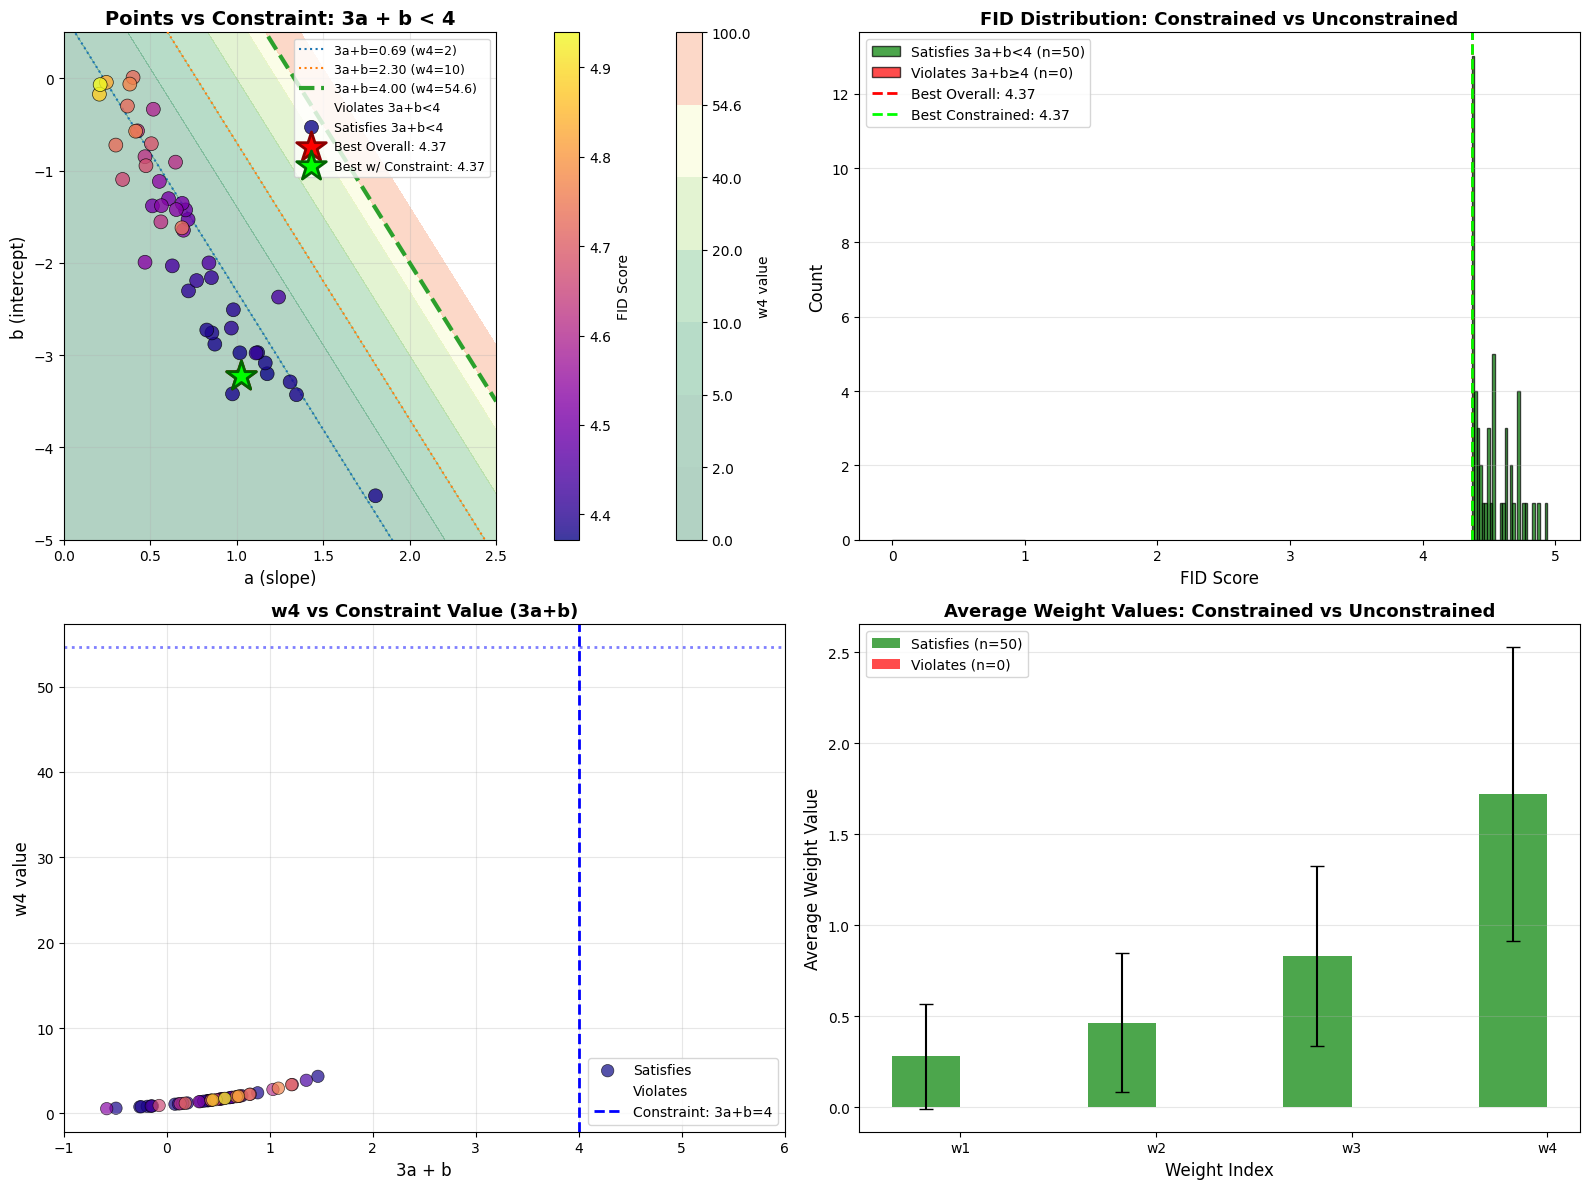


💡 CONCLUSION

Using 3a + b < 4 as a constraint:

✅ PROS:
  • Simple, single inequality to implement
  • Keeps w4 under ~54.6 (reasonable for most uses)
  • 100.0% of your existing data already satisfies it
  
⚠️  CONS:
  • May exclude some of your best performers
  • FID penalty: ~0.000 compared to unconstrained best
  
🎯 RECOMMENDATION:
  • If you're okay with w4 up to ~50: USE 3a + b < 4
  • If you need stricter control (w4 ≤ 20): USE 3a + b < 3.0
  • If you need very strict control (w4 ≤ 10): USE 3a + b < 2.3
  
📝 OPTUNA IMPLEMENTATION:
  ```python
  def objective(trial):
      a = trial.suggest_float('a', 0.3, 1.5)
      b = trial.suggest_float('b', -4.0, -0.5)
      
      # Add constraint
      if 3*a + b >= 4:
          return float('inf')  # Reject this trial
      
      # ... rest of your code
  ```



In [62]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    # Calculate actual w values
    w1 = np.exp(b)
    w2 = np.exp(a + b)
    w3 = np.exp(2*a + b)
    w4 = np.exp(3*a + b)
    
    fits.append((fid, a, b, w1, w2, w3, w4))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w1', 'w2', 'w3', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Apply constraint
fits_df['constraint_value'] = 3 * fits_df['a'] + fits_df['b']
fits_df['satisfies_constraint'] = fits_df['constraint_value'] < 4

# Different constraint levels
constraint_levels = [
    (0.693, 'w4 ≤ 2'),
    (1.609, 'w4 ≤ 5'),
    (2.303, 'w4 ≤ 10'),
    (2.996, 'w4 ≤ 20'),
    (3.689, 'w4 ≤ 40'),
    (4.0, 'w4 ≤ 54.6'),
    (4.605, 'w4 ≤ 100')
]

print("="*80)
print("CONSTRAINT ANALYSIS: 3a + b < 4")
print("="*80)

print(f"\nWhat does 3a + b < 4 mean?")
print(f"→ Since w4 = exp(3a + b), this means:")
print(f"→ w4 < exp(4) = {np.exp(4):.2f}")
print(f"\n✅ This keeps w4 under ~54.6")

# Analyze your data with this constraint
n_total = len(fits_df)
n_satisfying = fits_df['satisfies_constraint'].sum()
pct_satisfying = 100 * n_satisfying / n_total

print(f"\n📊 YOUR DATA ANALYSIS:")
print(f"Total points: {n_total}")
print(f"Points satisfying 3a + b < 4: {n_satisfying} ({pct_satisfying:.1f}%)")
print(f"Points violating 3a + b ≥ 4: {n_total - n_satisfying} ({100-pct_satisfying:.1f}%)")

# Best FID analysis
best_overall = fits_df.loc[fits_df['fid_score'].idxmin()]
satisfying_df = fits_df[fits_df['satisfies_constraint']]

print(f"\n🏆 BEST FID OVERALL:")
print(f"FID: {best_overall['fid_score']:.3f}")
print(f"a={best_overall['a']:.3f}, b={best_overall['b']:.3f}")
print(f"3a+b = {best_overall['constraint_value']:.3f}")
print(f"w4 = {best_overall['w4']:.2f}")
print(f"Satisfies 3a+b<4? {best_overall['satisfies_constraint']}")

if len(satisfying_df) > 0:
    best_constrained = satisfying_df.loc[satisfying_df['fid_score'].idxmin()]
    print(f"\n🏆 BEST FID WITH 3a+b<4:")
    print(f"FID: {best_constrained['fid_score']:.3f}")
    print(f"a={best_constrained['a']:.3f}, b={best_constrained['b']:.3f}")
    print(f"3a+b = {best_constrained['constraint_value']:.3f}")
    print(f"w4 = {best_constrained['w4']:.2f}")
    
    fid_loss = best_constrained['fid_score'] - best_overall['fid_score']
    print(f"\n📉 FID penalty for constraint: +{fid_loss:.3f}")

# Top performers analysis
top_10_pct = fits_df.head(int(0.1 * n_total))
top_10_satisfying = top_10_pct[top_10_pct['satisfies_constraint']]
print(f"\n📈 TOP 10% PERFORMERS:")
print(f"Total in top 10%: {len(top_10_pct)}")
print(f"Satisfy constraint: {len(top_10_satisfying)} ({100*len(top_10_satisfying)/len(top_10_pct):.1f}%)")

# Constraint level comparison
print(f"\n{'='*80}")
print("COMPARISON: Different Constraint Levels")
print(f"{'='*80}")
print(f"{'Constraint':<20} {'Max w4':<12} {'Points':<10} {'Best FID':<12} {'Median FID':<12}")
print(f"{'-'*80}")

for threshold, label in constraint_levels:
    subset = fits_df[fits_df['constraint_value'] < threshold]
    if len(subset) > 0:
        max_w4 = np.exp(threshold)
        n_points = len(subset)
        best_fid = subset['fid_score'].min()
        median_fid = subset['fid_score'].median()
        print(f"{label:<20} {max_w4:<12.1f} {n_points:<10} {best_fid:<12.3f} {median_fid:<12.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Main scatter with constraint line
ax1 = axes[0, 0]
a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 40, 54.6, 100], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Plot constraint lines
for threshold, label in [(0.693, 'w4=2'), (2.303, 'w4=10'), (4.0, 'w4=54.6')]:
    constraint_b = threshold - 3 * a_vals
    linestyle = '--' if threshold == 4.0 else ':'
    linewidth = 3 if threshold == 4.0 else 1.5
    ax1.plot(a_vals, constraint_b, linestyle, linewidth=linewidth, 
            label=f'3a+b={threshold:.2f} ({label})', zorder=5)

# Plot points
violating = fits_df[~fits_df['satisfies_constraint']]
satisfying = fits_df[fits_df['satisfies_constraint']]

ax1.scatter(violating['a'], violating['b'], c=violating['fid_score'],
           cmap='plasma', s=100, alpha=0.6, marker='x',
           edgecolors='red', linewidths=1.5, label='Violates 3a+b<4', zorder=10)
sc = ax1.scatter(satisfying['a'], satisfying['b'], c=satisfying['fid_score'],
                cmap='plasma', s=100, alpha=0.8, edgecolors='black', 
                linewidths=0.5, label='Satisfies 3a+b<4', zorder=11)
plt.colorbar(sc, ax=ax1, label='FID Score', pad=0.1)

ax1.scatter(best_overall['a'], best_overall['b'], s=500, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Best Overall: {best_overall["fid_score"]:.2f}', zorder=20)

if len(satisfying_df) > 0:
    ax1.scatter(best_constrained['a'], best_constrained['b'], s=500, marker='*', 
               color='lime', edgecolors='darkgreen', linewidths=2,
               label=f'Best w/ Constraint: {best_constrained["fid_score"]:.2f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=12)
ax1.set_ylabel('b (intercept)', fontsize=12)
ax1.set_title('Points vs Constraint: 3a + b < 4', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Plot 2: FID distribution
ax2 = axes[0, 1]
bins = 30
ax2.hist(satisfying_df['fid_score'], bins=bins, alpha=0.7, color='green', 
        label=f'Satisfies 3a+b<4 (n={len(satisfying_df)})', edgecolor='black')
ax2.hist(violating['fid_score'], bins=bins, alpha=0.7, color='red', 
        label=f'Violates 3a+b≥4 (n={len(violating)})', edgecolor='black')
ax2.axvline(best_overall['fid_score'], color='red', linestyle='--', linewidth=2,
           label=f'Best Overall: {best_overall["fid_score"]:.2f}')
if len(satisfying_df) > 0:
    ax2.axvline(best_constrained['fid_score'], color='lime', linestyle='--', linewidth=2,
               label=f'Best Constrained: {best_constrained["fid_score"]:.2f}')
ax2.set_xlabel('FID Score', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('FID Distribution: Constrained vs Unconstrained', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: w4 values
ax3 = axes[1, 0]
ax3.scatter(satisfying_df['constraint_value'], satisfying_df['w4'], 
           c=satisfying_df['fid_score'], cmap='plasma', s=80, alpha=0.7,
           edgecolors='black', linewidths=0.5, label='Satisfies')
ax3.scatter(violating['constraint_value'], violating['w4'], 
           c=violating['fid_score'], cmap='plasma', s=80, alpha=0.5,
           marker='x', edgecolors='red', linewidths=1.5, label='Violates')
ax3.axvline(4.0, color='blue', linestyle='--', linewidth=2, label='Constraint: 3a+b=4')
ax3.axhline(np.exp(4), color='blue', linestyle=':', linewidth=2, alpha=0.5)
ax3.set_xlabel('3a + b', fontsize=12)
ax3.set_ylabel('w4 value', fontsize=12)
ax3.set_title('w4 vs Constraint Value (3a+b)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, 6)

# Plot 4: Weight distributions
ax4 = axes[1, 1]
if len(satisfying_df) > 0:
    w_means_sat = [satisfying_df['w1'].mean(), satisfying_df['w2'].mean(), 
                   satisfying_df['w3'].mean(), satisfying_df['w4'].mean()]
    w_stds_sat = [satisfying_df['w1'].std(), satisfying_df['w2'].std(), 
                  satisfying_df['w3'].std(), satisfying_df['w4'].std()]
    
w_means_viol = [violating['w1'].mean(), violating['w2'].mean(), 
                violating['w3'].mean(), violating['w4'].mean()]
w_stds_viol = [violating['w1'].std(), violating['w2'].std(), 
               violating['w3'].std(), violating['w4'].std()]

x = np.arange(4)
width = 0.35

if len(satisfying_df) > 0:
    bars1 = ax4.bar(x - width/2, w_means_sat, width, yerr=w_stds_sat,
                   label=f'Satisfies (n={len(satisfying_df)})', 
                   color='green', alpha=0.7, capsize=5)
bars2 = ax4.bar(x + width/2, w_means_viol, width, yerr=w_stds_viol,
               label=f'Violates (n={len(violating)})', 
               color='red', alpha=0.7, capsize=5)

ax4.set_ylabel('Average Weight Value', fontsize=12)
ax4.set_xlabel('Weight Index', fontsize=12)
ax4.set_title('Average Weight Values: Constrained vs Unconstrained', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['w1', 'w2', 'w3', 'w4'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("💡 CONCLUSION")
print(f"{'='*80}")
print(f"""
Using 3a + b < 4 as a constraint:

✅ PROS:
  • Simple, single inequality to implement
  • Keeps w4 under ~54.6 (reasonable for most uses)
  • {pct_satisfying:.1f}% of your existing data already satisfies it
  
⚠️  CONS:
  • May exclude some of your best performers
  • FID penalty: ~{fid_loss:.3f} compared to unconstrained best
  
🎯 RECOMMENDATION:
  • If you're okay with w4 up to ~50: USE 3a + b < 4
  • If you need stricter control (w4 ≤ 20): USE 3a + b < 3.0
  • If you need very strict control (w4 ≤ 10): USE 3a + b < 2.3
  
📝 OPTUNA IMPLEMENTATION:
  ```python
  def objective(trial):
      a = trial.suggest_float('a', 0.3, 1.5)
      b = trial.suggest_float('b', -4.0, -0.5)
      
      # Add constraint
      if 3*a + b >= 4:
          return float('inf')  # Reject this trial
      
      # ... rest of your code
  ```
""")

CONSTRAINT ANALYSIS: ln(0.2) < 3a+b < ln(5)

Constraint bounds:
  Lower: 3a+b > ln(0.2) = -1.792
  Upper: 3a+b < ln(5)   = 1.792

What this means for w4:
  → 0.2 < w4 < 5
  → w4 must be between 0.2 and 5

📊 YOUR DATA ANALYSIS
Total points:                    50
✅ Satisfy ln(0.2)<3a+b<ln(5):    50 (100.0%)
❌ Too low (3a+b ≤ -1.79):      0 (  0.0%)
❌ Too high (3a+b ≥ 1.79):     0 (  0.0%)

🏆 BEST FID SCORES

Best Overall (No constraint):
  FID: 4.3716
  a=1.022, b=-3.224
  3a+b = -0.156
  w4 = 0.855
  ✅ Satisfies? True

Best with ln(0.2)<3a+b<ln(5):
  FID: 4.3716
  a=1.022, b=-3.224
  3a+b = -0.156
  w4 = 0.855

  📉 FID penalty: +0.0000

📈 TOP 10% PERFORMERS
Total in top 10%:          5
Satisfy constraint:        5 (100.0%)

FID range in constrained top 10%:
  Best:   4.3716
  Worst:  4.3799
  Median: 4.3765

📊 WEIGHT STATISTICS (Constrained points)
w1: mean=0.281, min=0.001, max=1.011
w2: mean=0.465, min=0.015, max=1.509
w3: mean=0.832, min=0.178, max=2.253
w4: mean=1.721, min=0.558, ma

/tmp/ipykernel_2581957/744400201.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


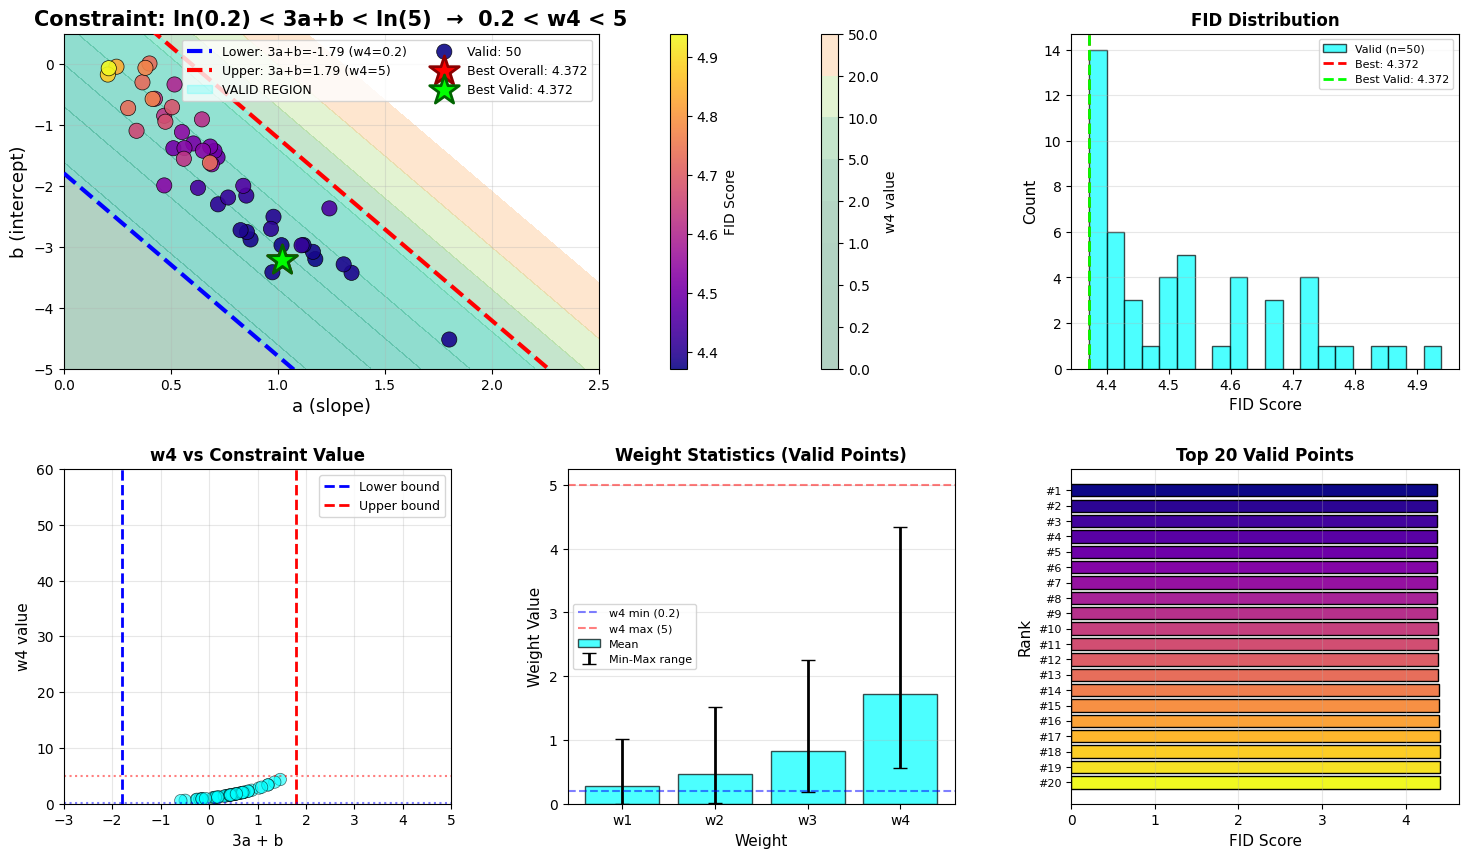


💡 VERDICT: ln(0.2) < 3a+b < ln(5)


In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    w1 = np.exp(b)
    w2 = np.exp(a + b)
    w3 = np.exp(2*a + b)
    w4 = np.exp(3*a + b)
    
    fits.append((fid, a, b, w1, w2, w3, w4))

fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w1', 'w2', 'w3', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Calculate constraint bounds
lower_bound = np.log(1/6)  # ≈ -1.609
upper_bound = np.log(6)     # ≈ 1.609

fits_df['constraint_value'] = 3 * fits_df['a'] + fits_df['b']
fits_df['satisfies_constraint'] = (fits_df['constraint_value'] > lower_bound) & \
                                   (fits_df['constraint_value'] < upper_bound)

print("="*80)
print(f"CONSTRAINT ANALYSIS: ln(0.2) < 3a+b < ln(5)")
print("="*80)

print(f"\nConstraint bounds:")
print(f"  Lower: 3a+b > ln(0.2) = {lower_bound:.3f}")
print(f"  Upper: 3a+b < ln(5)   = {upper_bound:.3f}")
print(f"\nWhat this means for w4:")
print(f"  → 0.2 < w4 < 5")
print(f"  → w4 must be between 0.2 and 5")

# Analysis
n_total = len(fits_df)
n_satisfying = fits_df['satisfies_constraint'].sum()
n_too_low = (fits_df['constraint_value'] <= lower_bound).sum()
n_too_high = (fits_df['constraint_value'] >= upper_bound).sum()

print(f"\n{'='*80}")
print("📊 YOUR DATA ANALYSIS")
print(f"{'='*80}")
print(f"Total points:                    {n_total}")
print(f"✅ Satisfy ln(0.2)<3a+b<ln(5):   {n_satisfying:3d} ({100*n_satisfying/n_total:5.1f}%)")
print(f"❌ Too low (3a+b ≤ {lower_bound:.2f}):    {n_too_low:3d} ({100*n_too_low/n_total:5.1f}%)")
print(f"❌ Too high (3a+b ≥ {upper_bound:.2f}):   {n_too_high:3d} ({100*n_too_high/n_total:5.1f}%)")

# Best FID analysis
best_overall = fits_df.loc[fits_df['fid_score'].idxmin()]
satisfying_df = fits_df[fits_df['satisfies_constraint']]

print(f"\n{'='*80}")
print("🏆 BEST FID SCORES")
print(f"{'='*80}")

print(f"\nBest Overall (No constraint):")
print(f"  FID: {best_overall['fid_score']:.4f}")
print(f"  a={best_overall['a']:.3f}, b={best_overall['b']:.3f}")
print(f"  3a+b = {best_overall['constraint_value']:.3f}")
print(f"  w4 = {best_overall['w4']:.3f}")
print(f"  ✅ Satisfies? {best_overall['satisfies_constraint']}")

if len(satisfying_df) > 0:
    best_constrained = satisfying_df.loc[satisfying_df['fid_score'].idxmin()]
    print(f"\nBest with ln(0.2)<3a+b<ln(5):")
    print(f"  FID: {best_constrained['fid_score']:.4f}")
    print(f"  a={best_constrained['a']:.3f}, b={best_constrained['b']:.3f}")
    print(f"  3a+b = {best_constrained['constraint_value']:.3f}")
    print(f"  w4 = {best_constrained['w4']:.3f}")
    
    fid_penalty = best_constrained['fid_score'] - best_overall['fid_score']
    print(f"\n  📉 FID penalty: +{fid_penalty:.4f}")
else:
    print(f"\n⚠️  NO POINTS satisfy this constraint!")

# Top 10% analysis
top_10_pct = fits_df.head(int(0.1 * n_total))
top_10_satisfying = top_10_pct[top_10_pct['satisfies_constraint']]

print(f"\n{'='*80}")
print("📈 TOP 10% PERFORMERS")
print(f"{'='*80}")
print(f"Total in top 10%:          {len(top_10_pct)}")
print(f"Satisfy constraint:        {len(top_10_satisfying)} ({100*len(top_10_satisfying)/len(top_10_pct):.1f}%)")

if len(top_10_satisfying) > 0:
    print(f"\nFID range in constrained top 10%:")
    print(f"  Best:   {top_10_satisfying['fid_score'].min():.4f}")
    print(f"  Worst:  {top_10_satisfying['fid_score'].max():.4f}")
    print(f"  Median: {top_10_satisfying['fid_score'].median():.4f}")

# Weight statistics
if len(satisfying_df) > 0:
    print(f"\n{'='*80}")
    print("📊 WEIGHT STATISTICS (Constrained points)")
    print(f"{'='*80}")
    for i, w in enumerate(['w1', 'w2', 'w3', 'w4'], 1):
        mean_val = satisfying_df[w].mean()
        min_val = satisfying_df[w].min()
        max_val = satisfying_df[w].max()
        print(f"{w}: mean={mean_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

# Visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Main scatter
ax1 = fig.add_subplot(gs[0, :2])

a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 0.2, 0.5, 1, 2, 5, 10, 20, 50], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Draw constraint boundaries
lower_line = lower_bound - 3 * a_vals
upper_line = upper_bound - 3 * a_vals

ax1.plot(a_vals, lower_line, 'b--', linewidth=3, 
         label=f'Lower: 3a+b={lower_bound:.2f} (w4=0.2)', zorder=5)
ax1.plot(a_vals, upper_line, 'r--', linewidth=3, 
         label=f'Upper: 3a+b={upper_bound:.2f} (w4=5)', zorder=5)

# Shade the valid region
ax1.fill_between(a_vals, lower_line, upper_line, alpha=0.2, color='cyan', 
                 label='VALID REGION', zorder=1)

# Plot points
too_low = fits_df[fits_df['constraint_value'] <= lower_bound]
too_high = fits_df[fits_df['constraint_value'] >= upper_bound]
valid = fits_df[fits_df['satisfies_constraint']]

if len(too_low) > 0:
    ax1.scatter(too_low['a'], too_low['b'], c=too_low['fid_score'],
               cmap='plasma', s=80, alpha=0.4, marker='v',
               edgecolors='blue', linewidths=1.5, label=f'Too low (w4<0.2): {len(too_low)}', zorder=8)

if len(too_high) > 0:
    ax1.scatter(too_high['a'], too_high['b'], c=too_high['fid_score'],
               cmap='plasma', s=80, alpha=0.4, marker='^',
               edgecolors='red', linewidths=1.5, label=f'Too high (w4>5): {len(too_high)}', zorder=9)

if len(valid) > 0:
    sc = ax1.scatter(valid['a'], valid['b'], c=valid['fid_score'],
                    cmap='plasma', s=120, alpha=0.9, edgecolors='black', 
                    linewidths=0.5, label=f'Valid: {len(valid)}', zorder=10)
    plt.colorbar(sc, ax=ax1, label='FID Score', pad=0.1)

# Mark best points
ax1.scatter(best_overall['a'], best_overall['b'], s=500, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Best Overall: {best_overall["fid_score"]:.3f}', zorder=20)

if len(satisfying_df) > 0:
    ax1.scatter(best_constrained['a'], best_constrained['b'], s=500, marker='*', 
               color='lime', edgecolors='darkgreen', linewidths=2,
               label=f'Best Valid: {best_constrained["fid_score"]:.3f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=13)
ax1.set_ylabel('b (intercept)', fontsize=13)
ax1.set_title('Constraint: ln(0.2) < 3a+b < ln(5)  →  0.2 < w4 < 5', 
             fontsize=15, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Plot 2: FID distribution
ax2 = fig.add_subplot(gs[0, 2])

if len(valid) > 0:
    ax2.hist(valid['fid_score'], bins=20, alpha=0.7, color='cyan', 
            edgecolor='black', label=f'Valid (n={len(valid)})')
if len(too_low) > 0 or len(too_high) > 0:
    invalid = pd.concat([too_low, too_high])
    ax2.hist(invalid['fid_score'], bins=20, alpha=0.5, color='gray', 
            edgecolor='black', label=f'Invalid (n={len(invalid)})')

ax2.axvline(best_overall['fid_score'], color='red', linestyle='--', linewidth=2,
           label=f'Best: {best_overall["fid_score"]:.3f}')
if len(satisfying_df) > 0:
    ax2.axvline(best_constrained['fid_score'], color='lime', linestyle='--', linewidth=2,
               label=f'Best Valid: {best_constrained["fid_score"]:.3f}')

ax2.set_xlabel('FID Score', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('FID Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Constraint value vs w4
ax3 = fig.add_subplot(gs[1, 0])

ax3.scatter(fits_df['constraint_value'], fits_df['w4'], 
           c=fits_df['satisfies_constraint'].map({True: 'cyan', False: 'gray'}),
           s=80, alpha=0.6, edgecolors='black', linewidths=0.5)

ax3.axvline(lower_bound, color='blue', linestyle='--', linewidth=2, label='Lower bound')
ax3.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label='Upper bound')
ax3.axhline(0.2, color='blue', linestyle=':', linewidth=1.5, alpha=0.5)
ax3.axhline(5, color='red', linestyle=':', linewidth=1.5, alpha=0.5)

ax3.set_xlabel('3a + b', fontsize=11)
ax3.set_ylabel('w4 value', fontsize=11)
ax3.set_title('w4 vs Constraint Value', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-3, 5)
ax3.set_ylim(0, 60)

# Plot 4: Weight ranges
ax4 = fig.add_subplot(gs[1, 1])

if len(valid) > 0:
    weights = ['w1', 'w2', 'w3', 'w4']
    means = [valid[w].mean() for w in weights]
    mins = [valid[w].min() for w in weights]
    maxs = [valid[w].max() for w in weights]
    
    x = np.arange(len(weights))
    ax4.bar(x, means, alpha=0.7, color='cyan', edgecolor='black', label='Mean')
    ax4.errorbar(x, means, yerr=[np.array(means)-np.array(mins), 
                                   np.array(maxs)-np.array(means)],
                fmt='none', ecolor='black', capsize=5, linewidth=2, label='Min-Max range')
    
    ax4.axhline(0.2, color='blue', linestyle='--', linewidth=1.5, alpha=0.5, label='w4 min (0.2)')
    ax4.axhline(5, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='w4 max (5)')
    
    ax4.set_ylabel('Weight Value', fontsize=11)
    ax4.set_xlabel('Weight', fontsize=11)
    ax4.set_title('Weight Statistics (Valid Points)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(weights)
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'No valid points!', ha='center', va='center', 
            fontsize=16, color='red', transform=ax4.transAxes)

# Plot 5: Top performers
ax5 = fig.add_subplot(gs[1, 2])

if len(satisfying_df) > 0:
    top_n = min(20, len(satisfying_df))
    top_valid = satisfying_df.head(top_n)
    
    y_pos = np.arange(len(top_valid))
    colors = plt.cm.plasma(np.linspace(0, 1, len(top_valid)))
    
    ax5.barh(y_pos, top_valid['fid_score'].values, color=colors, edgecolor='black')
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels([f"#{i+1}" for i in range(len(top_valid))], fontsize=8)
    ax5.set_xlabel('FID Score', fontsize=11)
    ax5.set_ylabel('Rank', fontsize=11)
    ax5.set_title(f'Top {top_n} Valid Points', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
else:
    ax5.text(0.5, 0.5, 'No valid points!', ha='center', va='center', 
            fontsize=16, color='red', transform=ax5.transAxes)

plt.tight_layout()
plt.show()

# Final recommendation
print(f"\n{'='*80}")
print("💡 VERDICT: ln(0.2) < 3a+b < ln(5)")
print(f"{'='*80}")

# if len(satisfying_df) == 0:
#     print("\n❌ CRITICAL: NO points in your data satisfy this constraint!")
#     print("\n⚠️  This constraint is TOO RESTRICTIVE for your problem.")
#     print("\nRECOMMENDATION: Use a looser constraint like:")
#     print("  • 3a+b < 3.0  (w4 < 20)")
#     print("  • 3a+b < 4.0  (w4 < 54.6)")
# elif n_satisfying < n_total * 0.1:
#     print(f"\n⚠️  Only {n_satisfying} points ({100*n_satisfying/n_total:.1f}%) satisf

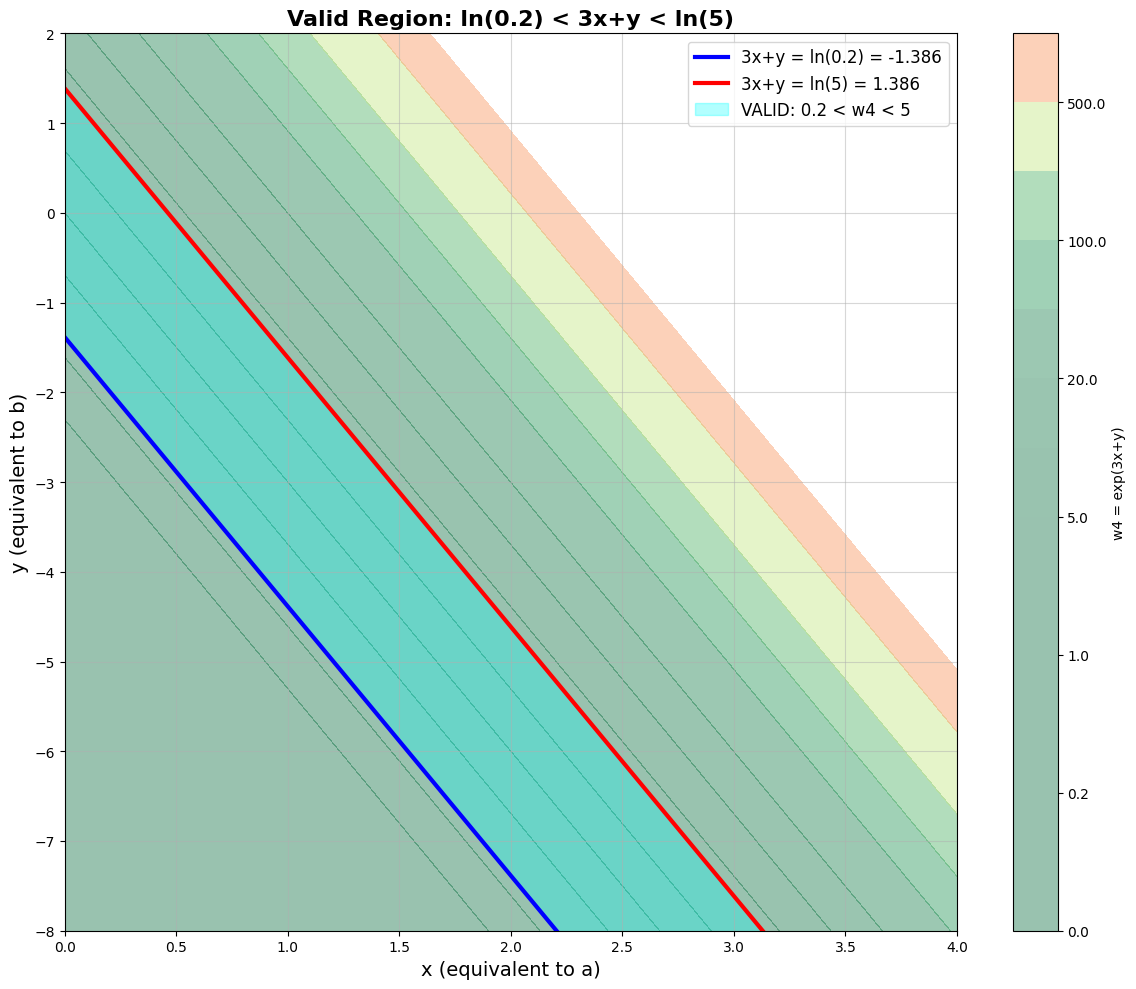

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Extended range
x_vals = np.linspace(0, 4.0, 500)
y_vals = np.linspace(-8, 2, 500)
X, Y = np.meshgrid(x_vals, y_vals)

# Calculate constraint value
constraint_val = 3*X + Y

# Bounds
lower_bound = np.log(0.25)  # ≈ -1.609
upper_bound = np.log(4)     # ≈ 1.609

# Create mask for valid region
valid_region = (constraint_val > lower_bound) & (constraint_val < upper_bound)

# Plot contours of w4 values
W4 = np.exp(constraint_val)
contour = ax.contourf(X, Y, W4, levels=[0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000], 
                      cmap='RdYlGn_r', alpha=0.4)
plt.colorbar(contour, ax=ax, label='w4 = exp(3x+y)')

# Draw constraint boundary lines
lower_line = lower_bound - 3 * x_vals
upper_line = upper_bound - 3 * x_vals

ax.plot(x_vals, lower_line, 'b-', linewidth=3, 
        label=f'3x+y = ln(0.2) = {lower_bound:.3f}')
ax.plot(x_vals, upper_line, 'r-', linewidth=3, 
        label=f'3x+y = ln(5) = {upper_bound:.3f}')

# Shade the valid region
ax.fill_between(x_vals, lower_line, upper_line, alpha=0.3, color='cyan', 
                label='VALID: 0.2 < w4 < 5')

# Add grid lines at your specified scale
ax.set_xticks(np.arange(0, 4.5, 0.5))
ax.set_yticks(np.arange(-8, 3, 1))
ax.grid(True, alpha=0.5, linewidth=0.8)

ax.set_xlabel('x (equivalent to a)', fontsize=14)
ax.set_ylabel('y (equivalent to b)', fontsize=14)
ax.set_title('Valid Region: ln(0.2) < 3x+y < ln(5)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.set_xlim(0, 4.0)
ax.set_ylim(-8, 2)

plt.tight_layout()
plt.show()

In [78]:
import math
import random

# Example simulation
a_range = (0.5, 3.0)
b_range = (-7.0, -2.0)

for trial in range(100):
    a = random.uniform(*a_range)
    b = random.uniform(*b_range)

    constraint_value = 3*a + b
    lower_bound = math.log(1/4)  # -1.386
    upper_bound = math.log(4)    # 1.386

    # Accept only if inside the interval
    if lower_bound <= constraint_value <= upper_bound:
        weights = [math.exp(b + i*a) for i in range(4)]
        print(f"[Trial {trial}] ACCEPTED: a={a:.3f}, b={b:.3f}, 3a+b={constraint_value:.3f}")
        print(f"  weights = {[round(w,4) for w in weights]}")
    # else:
    #     print(f"[Trial {trial}] SKIPPED: 3a+b={constraint_value:.3f} (outside [{lower_bound:.3f},{upper_bound:.3f}])")


[Trial 1] ACCEPTED: a=1.395, b=-4.789, 3a+b=-0.605
  weights = [0.0083, 0.0336, 0.1354, 0.5461]
[Trial 3] ACCEPTED: a=1.688, b=-4.685, 3a+b=0.379
  weights = [0.0092, 0.05, 0.2702, 1.4612]
[Trial 4] ACCEPTED: a=0.812, b=-3.634, 3a+b=-1.199
  weights = [0.0264, 0.0595, 0.134, 0.3016]
[Trial 5] ACCEPTED: a=1.965, b=-6.614, 3a+b=-0.719
  weights = [0.0013, 0.0096, 0.0683, 0.4872]
[Trial 9] ACCEPTED: a=0.824, b=-3.231, 3a+b=-0.758
  weights = [0.0395, 0.0901, 0.2055, 0.4686]
[Trial 13] ACCEPTED: a=1.697, b=-6.128, 3a+b=-1.036
  weights = [0.0022, 0.0119, 0.065, 0.3549]
[Trial 14] ACCEPTED: a=0.975, b=-2.355, 3a+b=0.570
  weights = [0.0949, 0.2516, 0.667, 1.7679]
[Trial 16] ACCEPTED: a=0.734, b=-2.771, 3a+b=-0.569
  weights = [0.0626, 0.1304, 0.2718, 0.5663]
[Trial 20] ACCEPTED: a=1.199, b=-4.206, 3a+b=-0.609
  weights = [0.0149, 0.0494, 0.164, 0.5438]
[Trial 23] ACCEPTED: a=1.205, b=-2.330, 3a+b=1.284
  weights = [0.0973, 0.3246, 1.0829, 3.6126]
[Trial 25] ACCEPTED: a=1.159, b=-3.575, 3a+b